In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
(train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_x = (train_x - 127.5) / 127.5
train_x = train_x.reshape(-1, 28, 28, 1).astype("float32")

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_x.shape

(60000, 28, 28, 1)

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(60000).batch(256)

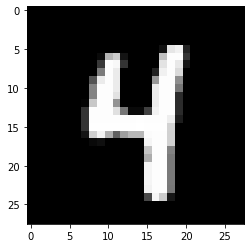

In [5]:
for image_batch in dataset:
    plt.imshow(image_batch[0,:,:,0], cmap='gray')
    break

In [6]:
generator = tf.keras.Sequential(
    [
     layers.Dense(7 * 7 * 256, input_shape=(100, )),
     layers.Reshape((7, 7, 256)),

     layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
     layers.BatchNormalization(),
     layers.LeakyReLU(alpha=0.01),

     layers.Conv2DTranspose(64, 3, strides=1, padding='same'),
     layers.BatchNormalization(),
     layers.LeakyReLU(alpha=0.01),

     layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='tanh')

    ]
)

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        2

In [8]:
discriminator = tf.keras.Sequential(
    [
     layers.Conv2D(32, 3, strides=2, input_shape=(28, 28, 1), padding='same'),
     layers.LeakyReLU(alpha=0.01),

     layers.Conv2D(64, 3, strides=2, padding='same'),
     layers.LeakyReLU(alpha=0.01),

     layers.Conv2D(128, 3, strides=2, padding='same'),
     layers.LeakyReLU(alpha=0.01),

     layers.Flatten(),
     layers.Dense(1, activation='sigmoid')
    ]
)

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)             

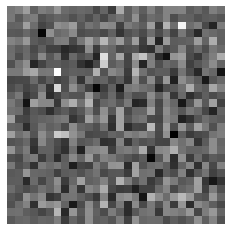

In [10]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [11]:
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50034994]], dtype=float32)>

In [12]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
gen_opt = tf.keras.optimizers.Adam(0.0001)
disc_opt = tf.keras.optimizers.Adam(0.0001)

In [19]:
epochs = 40
batch_size = 256

for epoch in range(epochs):
    for real_images in dataset:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = generator(tf.random.normal([batch_size, 100]))
            fake_output = discriminator(fake_images)
            real_output = discriminator(real_images)

            disc_fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_real_loss = loss_fn(tf.ones_like(real_output), real_output)
            disc_loss = disc_fake_loss + disc_real_loss

            gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)

        graident_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_opt.apply_gradients(zip(graident_of_generator, generator.trainable_variables))
        disc_opt.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    print("[ {} : {} ] G loss : {}, D loss : {}".format(epoch+1, epochs, gen_loss, disc_loss))
            

[ 1 : 40 ] G loss : 1.0306159257888794, D loss : 1.0804075002670288
[ 2 : 40 ] G loss : 0.8133454918861389, D loss : 1.2628891468048096
[ 3 : 40 ] G loss : 1.0272293090820312, D loss : 1.1039931774139404
[ 4 : 40 ] G loss : 0.9027824997901917, D loss : 1.2415032386779785
[ 5 : 40 ] G loss : 1.0148959159851074, D loss : 1.031999111175537
[ 6 : 40 ] G loss : 0.9593310952186584, D loss : 1.1579711437225342
[ 7 : 40 ] G loss : 0.95376056432724, D loss : 1.218832015991211
[ 8 : 40 ] G loss : 0.8826498985290527, D loss : 1.227088212966919
[ 9 : 40 ] G loss : 1.0819090604782104, D loss : 1.0418555736541748
[ 10 : 40 ] G loss : 0.8059458136558533, D loss : 1.2849202156066895
[ 11 : 40 ] G loss : 0.952339768409729, D loss : 1.1987284421920776
[ 12 : 40 ] G loss : 0.875237762928009, D loss : 1.1833341121673584
[ 13 : 40 ] G loss : 0.8726866841316223, D loss : 1.3111116886138916
[ 14 : 40 ] G loss : 0.900804877281189, D loss : 1.1692273616790771
[ 15 : 40 ] G loss : 0.8675101399421692, D loss : 1

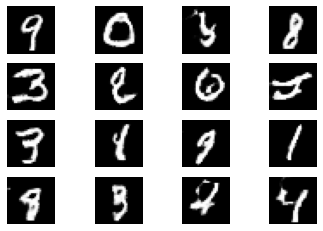

In [20]:
generated_images = generator(tf.random.normal([16, 100]))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i, :, :, 0].numpy()) * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()